<ipython-input-1-94cee2f4838e>:26: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


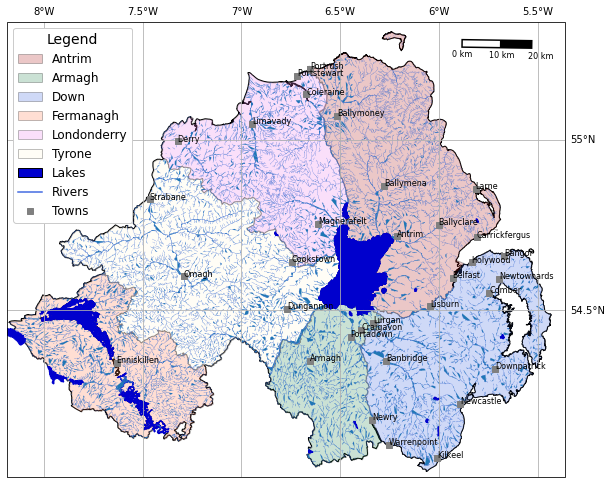

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles


# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]

    tmc = ccrs.TransverseMercator(sbllx, sblly)
    x0, x1, y0, y1 = ax.get_extent(tmc)
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    plt.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=tmc)
    plt.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=tmc)
    plt.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=tmc)

    plt.text(sbx, sby-4500, '20 km', transform=tmc, fontsize=8)
    plt.text(sbx-12500, sby-4500, '10 km', transform=tmc, fontsize=8)
    plt.text(sbx-24500, sby-4500, '0 km', transform=tmc, fontsize=8)


# load the datasets
outline = gpd.read_file('data_files/NI_outline.shp')
towns = gpd.read_file('data_files/Towns.shp')
water = gpd.read_file('data_files/Water.shp')
rivers = gpd.read_file('data_files/Rivers.shp')
counties = gpd.read_file('data_files/Counties.shp')

# create a figure of size 10x10 (representing the page size in inches)
myFig = plt.figure(figsize=(10, 10))

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.

ax = plt.axes(projection=ccrs.Mercator())  # finally, create an axes object in the figure, using a Mercator
# projection, where we can actually plot our data.

# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')

xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.

# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) # because total_bounds gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

# pick colors, add features to the map
county_colors = ['firebrick', 'seagreen', 'royalblue', 'coral', 'violet', 'cornsilk']

# get a list of unique names for the county boundaries
county_names = list(counties.CountyName.unique())
county_names.sort()  # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the list of names we created above
# we're also setting the edge color to be black, with a line width of 0.5 pt.
# Feel free to experiment with different colors and line widths.
for i, name in enumerate(county_names):
    feat = ShapelyFeature(counties['geometry'][counties['CountyName'] == name], myCRS,
                          edgecolor='k',
                          facecolor=county_colors[i],
                          linewidth=1,
                          alpha=0.25)
    ax.add_feature(feat)

# here, we're setting the edge color to be the same as the face color. Feel free to change this around,
# and experiment with different line widths.
water_feat = ShapelyFeature(water['geometry'], myCRS,
                            edgecolor='mediumblue',
                            facecolor='mediumblue',
                            linewidth=1)
ax.add_feature(water_feat)

river_feat = ShapelyFeature(rivers['geometry'], myCRS,
                            edgecolor='royalblue',
                            linewidth=0.2)

ax.add_feature(river_feat)

# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 's', color='0.5', ms=6, transform=myCRS)

# generate a list of handles for the county datasets
county_handles = generate_handles(counties.CountyName.unique(), county_colors, alpha=0.25)

# note: if you change the color you use to display lakes, you'll want to change it here, too
water_handle = generate_handles(['Lakes'], ['mediumblue'])

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]  # have to make this a list

# update county_names to take it out of uppercase text
nice_names = [name.title() for name in county_names]

# ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
handles = county_handles + water_handle + river_handle + town_handle
labels = nice_names + ['Lakes', 'Rivers', 'Towns']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=14,
                 fontsize=12, loc='upper left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],
                         ylocs=[54, 54.5, 55, 55.5])

gridlines.left_labels = False
gridlines.bottom_labels = False
ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS)

# add the text labels for the towns
for i, row in towns.iterrows():
    x, y = row.geometry.x, row.geometry.y
    plt.text(x, y, row['TOWN_NAME'].title(), fontsize=8, transform=myCRS) # use plt.text to place a label at x,y

scale_bar(ax)

myFig.savefig('map.png', bbox_inches='tight', dpi=300)
